## Creates binarized Seurat objects, and merges them and finds Top Features (min.cutoff=20)

In [2]:
# Input info
exp <- "preA"
sample_indir <- "/data2/isshamie/mito_lineage/data/processed/mtscATAC/DUPI_april08_2021_Croker/MTblacklist_mtasnucl/rxn1/outs/"
# External
external_dat_dir <- "/data/isshamie/mito_lineage/output/annotation/data/granja_cd3"
external_frag_file <- "/data/isshamie/mito_lineage/output/annotation/data/granja_cd34/granja_cd34.fragments.sort.tsv.gz"
external_prefix <- "GSE129785_scATAC-Hematopoiesis-CD34"

# Saving
outdir <- "/data2/mito_lineage/output/annotation/data/processed/mttrace/DUPI_april08_2021/MTblacklist_mtasnucl/Flt3l" #"/data2/mito_lineage/Analysis/annotation/output/data/"

# Parameters
nTop = 25000

In [4]:
print(sample_indir)
print(exp)

[1] "/data2/isshamie/mito_lineage/data/processed/mtscATAC/DUPI_april08_2021_Croker/MTblacklist_mtasnucl/rxn1/outs/"
[1] "preA"


In [5]:
# Change to the sorted fragment file!
ext_frag_file <- gsub('.fragments.tsv', '.fragments.sort.tsv.gz', external_frag_file)

In [6]:
external_dat_dir <- dirname(external_frag_file)
external_frag_file

[1] "/data/isshamie/mito_lineage/output/annotation/data/granja_cd34/granja_cd34.fragments.sort.tsv.gz"

In [1]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("GenomicRanges")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.10 (BiocManager 1.30.16), R 3.6.3 (2020-02-29)
Installing package(s) 'BiocVersion', 'GenomicRanges'
also installing the dependencies ‘bitops’, ‘RCurl’, ‘GenomeInfoDbData’, ‘zlibbioc’, ‘BiocGenerics’, ‘S4Vectors’, ‘IRanges’, ‘GenomeInfoDb’, ‘XVector’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'crayon', 'digest', 'evaluate', 'htmltools', 'IRdisplay',
  'IRkernel', 'jsonlite', 'pbdZMQ', 'Rcpp', 'repr', 'uuid'


In [3]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(future)
plan()
#plan("multiprocess", workers = workers)
options(future.globals.maxSize = 8000 * 1024^2)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The follow

ERROR: Error: package or namespace load failed for ‘Seurat’ in loadNamespace(i, c(lib.loc, .libPaths()), versionCheck = vI[[i]]):
 there is no package called ‘stringi’


## Merge peaks

In [8]:
sample_indir

[1] "/data2/isshamie/mito_lineage/data/processed/mtscATAC/DUPI_april08_2021_Croker/MTblacklist_mtasnucl/rxn1/outs/"

In [9]:
# read in peak sets
peaks.ext <- read.table(
  file = file.path(external_dat_dir, paste0(external_prefix, ".peaks.bed")),
  col.names = c("chr", "start", "end")
)


peaks.curr <- read.table(
  file = file.path(sample_indir, "filtered_peak_bc_matrix", "peaks.bed"),
  col.names = c("chr", "start", "end")
)


# convert to genomic ranges
gr.ext <- makeGRangesFromDataFrame(peaks.ext)
gr.curr <- makeGRangesFromDataFrame(peaks.curr)


# Create a unified set of peaks to quantify in each dataset
#combined.peaks <- reduce(x = c(gr.500, gr.1k, gr.5k, gr.10k))
combined.peaks <- reduce(x = c(gr.ext, gr.curr))

# Filter out bad peaks based on length
peakwidths <- width(combined.peaks)
combined.peaks <- combined.peaks[peakwidths  < 10000 & peakwidths > 20]
combined.peaks

GRanges object with 582414 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1       10238-10738      *
       [2]     chr1     115476-115976      *
       [3]     chr1     236856-237356      *
       [4]     chr1     237511-238011      *
       [5]     chr1     240801-241301      *
       ...      ...               ...    ...
  [582410]     chrY 11330004-11330096      *
  [582411]     chrY 11721760-11722256      *
  [582412]     chrY 11747538-11747879      *
  [582413]     chrY 56831591-56831901      *
  [582414]     chrY 56832845-56833062      *
  -------
  seqinfo: 25 sequences from an unspecified genome; no seqlengths

## Create fragment objects

In [10]:
barcode_path <- file.path(sample_indir, "filtered_peak_bc_matrix", "barcodes.tsv")
barcodes <- readr::read_tsv(barcode_path, col_names = F) # %>% tidyr::unite(barcode)

frag_file <- file.path(sample_indir, "fragments.tsv.gz")

# quantify multiome peaks in the scATAC-seq dataset
frags.curr <- CreateFragmentObject(path = frag_file,
                                  cells= barcodes[["X1"]])

barcodes <- as.data.frame(barcodes) %>%  tibble::column_to_rownames(var="X1") %>% tibble::add_column(proj=exp)

Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  X1 = col_character()
)


Computing hash



In [11]:
barcode_path <- file.path(external_dat_dir, paste0(external_prefix, ".cell_barcodes.txt"))


metadata <- read.csv(
  file = file.path(external_dat_dir, paste0(external_prefix, ".cell_barcodes.txt")),
  header = TRUE,
  sep='\t',
)
#CD34boo <- colData$Group %in% c("CD34_Progenitors_Rep1","CD34_Progenitors_Rep2")
c1boo <-  metadata$Group %in% c("BM_pDC", "CLP", "CMP", "GMP", "HSC", "LMPP", "MEP", "Monocytes", "MPP")
metadata <- metadata[c1boo,]

rownames(metadata) <- metadata$Group_Barcode
metadata$proj <- "granja_cd34"
ext_cell_names <- rownames(metadata)
metadata <- metadata[,c("Group", "proj")]
ext_cell_names

[1] "Monocytes#ATTTGTCCACAGAAGC-1"              
   [2] "Monocytes#ACTGCAATCTTCCAGC-1"              
   [3] "Monocytes#CCGAAGCGTCGTAGTT-1"              
   [4] "Monocytes#TGGAAGGCAAGGCGTA-1"              
   [5] "Monocytes#CGCACAGGTCACCCGA-1"              
   [6] "Monocytes#TTGCACCGTGAATCAA-1"              
   [7] "Monocytes#AATGGCTGTACATGGG-1"              
   [8] "Monocytes#ACTATTCGTCTCGGGT-1"              
   [9] "Monocytes#AGTGCGCTCGTCGCAG-1"              
  [10] "Monocytes#ACAGCGCTCACTCGGG-1"              
  [11] "Monocytes#CTCTCGAAGAAATGGG-1"              
  [12] "Monocytes#ACCATCCGTCGCTAGC-1"              
  [13] "Monocytes#AACCTTTCAACAAACA-1"              
  [14] "Monocytes#CTAGCGGTCGTGCTTC-1"              
  [15] "Monocytes#TTATGTCTCATTGCCC-1"              
  [16] "Monocytes#GTGCCAGGTTCCTATT-1"              
  [17] "Monocytes#GGATAGGAGATGAGGA-1"              
  [18] "Monocytes#AGCCTGGAGAACGCCA-1"              
  [19] "Monocytes#AACAAAGTCTTACTCA-1"              
  [20] "Monocytes#GGCGAAAGTGCGCATC-1"              
  [21] "Monocytes#CAGCTAACACGCGCAT-1"              
  [22] "Monocytes#CTTGAAGAGAGTTCGG-1"              
  [23] "Monocytes#GCGAGTCCACAAACAA-1"              
  [24] "Monocytes#GCATGATAGCTACGTT-1"              
  [25] "Monocytes#CACTAAGAGGCCAATG-1"              
  [26] "Monocytes#AATACGCAGCGTAGCA-1"              
  [27] "Monocytes#ACTGCGGAGGCAATTA-1"              
  [28] "Monocytes#GTTATTCTCGGTCTAA-1"              
  [29] "Monocytes#GCCCAGAAGTGTTCCA-1"              
  [30] "Monocytes#CCTTGCAGTATTCTTC-1"              
  [31] "Monocytes#GGAGAACAGAGCAGCT-1"              
  [32] "Monocytes#TTAGCGAGTGACGCAA-1"              
  [33] "Monocytes#TCAGGGCAGCATGATA-1"              
  [34] "Monocytes#TACATTCCAGATACAA-1"              
  [35] "Monocytes#GTGACATCATCGTACA-1"              
  [36] "Monocytes#GCTGTTCGTACGTATC-1"              
  [37] "Monocytes#TGACAACAGTCTGGGA-1"              
  [38] "Monocytes#GCTCAGGTCTAGCTGA-1"              
  [39] "Monocytes#GGCGTTGTCCCACTAC-1"              
  [40] "Monocytes#AGCCGCAAGGCAGTAC-1"              
  [41] "Monocytes#GAACTTGGTCTGAGCC-1"              
  [42] "Monocytes#GTAGTACCAATACTGC-1"              
  [43] "Monocytes#ATTACTCTCGCGCCAA-1"              
  [44] "Monocytes#AACAGTCCATCGTACA-1"              
  [45] "Monocytes#AGCCTTCTCCTTACGC-1"              
  [46] "Monocytes#TGCTATTGTTCCATCC-1"              
  [47] "Monocytes#AGTCCGGCACTAAACC-1"              
  [48] "Monocytes#ATCCAGAAGGTTACAA-1"              
  [49] "Monocytes#GAGGTCCTCGTCTTAT-1"              
  [50] "Monocytes#TAGCCCTGTAGCGAGT-1"              
  [51] "Monocytes#AAGGAGCCAGTATCTG-1"              
  [52] "Monocytes#TTGCGAACACACTAGT-1"              
  [53] "Monocytes#CTTGTCGCAACGGACA-1"              
  [54] "Monocytes#ACTGCGGGTAATGCAA-1"              
  [55] "Monocytes#TAATCGGGTGATGTGG-1"              
  [56] "Monocytes#GCATTCCCACTGTTAG-1"              
  [57] "Monocytes#AACTTGGTCAACACGT-1"              
  [58] "Monocytes#CTGGGACAGGGTAATT-1"              
  [59] "Monocytes#TGTACGAAGGGAAATG-1"              
  [60] "Monocytes#CCCTGATTCCGTCAAA-1"              
  [61] "Monocytes#GATCATGCATAGGCGA-1"              
  [62] "Monocytes#GGGACCTGTCTAAGAA-1"              
  [63] "Monocytes#GATCATGTCCATAACG-1"              
  [64] "Monocytes#TATGTTCCACTTGCGG-1"              
  [65] "Monocytes#TGGACATCAAGGGAGG-1"              
  [66] "Monocytes#CCTGCTATCTAAGGTC-1"              
  [67] "Monocytes#GTGTGATGTAGAATAC-1"              
  [68] "Monocytes#TCAGTTTTCGACTCGG-1"              
  [69] "Monocytes#CTGGCAGTCGCAACTA-1"              
  [70] "Monocytes#TGGCAATGTTAGCTCA-1"              
  [71] "Monocytes#GACCCAGAGTGCTAGG-1"              
  [72] "Monocytes#GACCAATCAAGCGGTA-1"              
  [73] "Monocytes#CATAACGAGGGTAATT-1"              
  [74] "Monocytes#TACGGATTCTTGTGCC-1"              
  [75] "Monocytes#TAACGGTGTCCACCAG-1"              
  [76] "Monocytes#ATATTCCTCAGAATGA-1"              
  [77] "Monocytes#GCCCGAAGTTGCCGCA-1"              

In [12]:
# quantify multiome peaks in the scATAC-seq dataset
frags.ext <- CreateFragmentObject(path = ext_frag_file,
                                  cells= ext_cell_names)

Computing hash



## Quantify peaks

In [13]:
ext.counts <- FeatureMatrix(
  fragments = frags.ext,
  features = combined.peaks,
  cells = rownames(metadata)
)

Extracting reads overlapping genomic regions



In [14]:
curr.counts <- FeatureMatrix(
  fragments = frags.curr,
  features = combined.peaks,
  cells = rownames(barcodes)
)


Extracting reads overlapping genomic regions



## Create the seurat objects 

In [15]:
ext_assay <- CreateChromatinAssay(ext.counts, fragments = frags.ext)
ext <- CreateSeuratObject(ext_assay, assay = "ATAC", project="granja_cd34", meta.data=metadata)


In [16]:
ext

An object of class Seurat 
582403 features across 2196 samples within 1 assay 
Active assay: ATAC (582403 features, 0 variable features)

In [17]:
curr_assay <- CreateChromatinAssay(curr.counts, fragments = frags.curr)
curr <- CreateSeuratObject(curr_assay, assay = "ATAC", project=exp, meta.data=barcodes)

Warning message in CreateSeuratObject.Assay(curr_assay, assay = "ATAC", project = exp, :
"Some cells in meta.data not present in provided counts matrix."


In [18]:
curr.counts

   [[ suppressing 31 column names 'AAACGAACAATCACTG-1', 'AAACGAATCTTACTCA-1', 'AAACTCGTCCGCCTAT-1' ... ]]

   [[ suppressing 31 column names 'AAACGAACAATCACTG-1', 'AAACGAATCTTACTCA-1', 'AAACTCGTCCGCCTAT-1' ... ]]

   [[ suppressing 31 column names 'AAACGAACAATCACTG-1', 'AAACGAATCTTACTCA-1', 'AAACTCGTCCGCCTAT-1' ... ]]



582414 x 450 sparse Matrix of class "dgCMatrix"
                                                                                         
chr1-10238-10738     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1-115476-115976   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1-236856-237356   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1-237511-238011   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1-240801-241301   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1-250084-250584   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1-540710-541210   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1-710379-710879   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1-714861-715361   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1-740068-740568   . . . . . . . . . . . . . . . .

In [19]:
curr

An object of class Seurat 
582414 features across 446 samples within 1 assay 
Active assay: ATAC (582414 features, 0 variable features)

In [20]:
ext <- BinarizeCounts(ext)
curr <- BinarizeCounts(curr)


In [21]:
#saveRDS(ext, file.path(outdir, external_dat_file))
#saveRDS(curr, file.path(outdir, paste0(exp, ".rds")))

## Merge the external and sample objects.

In [22]:
# merge all datasets, adding a cell ID to make sure cell names are unique
combined <- merge(
  x = ext,
  y = curr,
  add.cell.ids = c("ext", exp)
)
combined[["ATAC"]]

ChromatinAssay data with 582414 features for 2642 cells
Variable features: 0 
Genome: 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 2 

In [23]:
combined <- FindTopFeatures(combined, min.cutoff = 20)
combined

An object of class Seurat 
582414 features across 2642 samples within 1 assay 
Active assay: ATAC (582414 features, 157703 variable features)

## Create gene-expression counts using peaks near genes

In [ ]:
# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v75, biotypes = "protein_coding")
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- "hg38"
Annotation(combined) <- annotations
gene.activities <- GeneActivity(combined)

# add the gene activity matrix to the Seurat object as a new assay and normalize it
combined[['RNA']] <- CreateAssayObject(counts = gene.activities)
combined <- NormalizeData(
  object = combined,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(combined$nCount_RNA)
)

# Save

In [25]:
###### dir.create(outdir, recursive=T)
saveRDS(combined, file.path(outdir, paste0(exp, ".merged.rds")))

# Plot 

## Label by external or sample. Batch effect is clear

In [26]:
combined <- RunTFIDF(combined)
combined <- RunSVD(combined)
combined <- RunUMAP(combined, dims = 2:50, reduction = 'lsi')
p1 <- DimPlot(combined, group.by = "proj", pt.size = 0.1)

cowplot::ggsave2(p1, file = file.path(outdir, paste0(exp, ".merged.lsi.Batchlabels.png")), width = 1.7, height = 1.7)

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
17:10:44 UMAP embedding parameters a = 0.9922 b = 1.112

17:10:44 Read 2642 rows and found 49 numeric columns

17:10:44 Using Annoy for neighbor search, n_neighbors = 30

17:10:44 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:10:45 Writing NN index file to temp file /tmp/RtmpoRWf7e/

## Group by the labelled reference to make sure the cell types are still grouped.

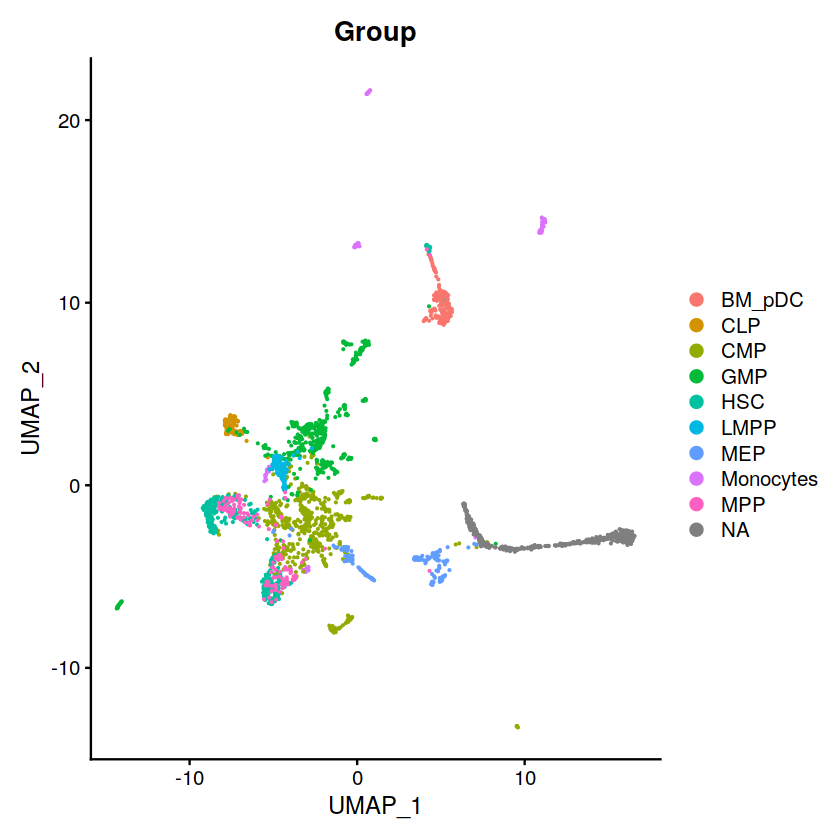

In [27]:
DimPlot(combined, group.by = "Group", pt.size = 0.1)
cowplot::ggsave2(p1, file = file.path(outdir, paste0(exp, ".merged.lsi.Extlabels.png")), width = 1.7, height = 1.7)

In [5]:
combined <- readRDS(file.path(outdir, paste0(exp, ".merged.rds")))
combined[[]]

,orig.ident,nCount_ATAC,nFeature_ATAC,Group,proj
,<chr>,<dbl>,<int>,<chr>,<chr>
ext_Monocytes#ATTTGTCCACAGAAGC-1,granja_cd34,10826,10826,Monocytes,granja_cd34
ext_Monocytes#ACTGCAATCTTCCAGC-1,granja_cd34,11955,11955,Monocytes,granja_cd34
ext_Monocytes#CCGAAGCGTCGTAGTT-1,granja_cd34,8273,8273,Monocytes,granja_cd34
ext_Monocytes#TGGAAGGCAAGGCGTA-1,granja_cd34,10924,10924,Monocytes,granja_cd34
ext_Monocytes#CGCACAGGTCACCCGA-1,granja_cd34,20737,20737,Monocytes,granja_cd34
ext_Monocytes#TTGCACCGTGAATCAA-1,granja_cd34,13129,13129,Monocytes,granja_cd34
ext_Monocytes#AATGGCTGTACATGGG-1,granja_cd34,12541,12541,Monocytes,granja_cd34
ext_Monocytes#ACTATTCGTCTCGGGT-1,granja_cd34,15328,15328,Monocytes,granja_cd34
ext_Monocytes#AGTGCGCTCGTCGCAG-1,granja_cd34,9742,9742,Monocytes,granja_cd34
